In [15]:
import math
import os.path
import pickle
import ipynb 
import os.path

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

from importlib import reload

In [28]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict, check_desc
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [29]:
# import functions from py file 

import functions.fun_meth_reflections
reload(functions.fun_meth_reflections)
from functions.fun_meth_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions.fun_meth_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class, w_star_analytic

In [30]:
# import functions from py file 

import functions.fun_external_factors
reload(functions.fun_external_factors)
from functions.fun_external_factors import rank_comparison, calibrate_analytic, create_exogenous_rank

In [31]:
# import classes 

import classes
reload(classes)

<module 'classes' from '/home/anita.mezzetti/bipartite_network/classes.py'>

## Update data

In [32]:
name_file_com = 'savings/classes/dict_companies_cybersecurity_10.pickle'
name_file_tech = 'savings/classes/dict_companies_cybersecurity_10.pickle'
name_file_graph = 'savings/networks/cybersecurity_comp_10_tech_26.gpickle'
name_M = 'savings/M/cybersecurity_comp_10_tech_26.npy'
flag_cybersecurity = True

In [33]:
with open(name_file_com, 'rb') as f:
    dict_companies = pickle.load(f)
    
with open(name_file_tech, 'rb') as f:
    dict_tech = pickle.load(f)

B = nx.read_gpickle(name_file_graph)

with open(name_M, 'rb') as f:
    M = np.load(f)

## Parameters calibration with exogenous variables.  <a class="anchor" id="pal_cal"></a>

An essential step is the calibration of $alpha$ and $beta$, i.e. find the *optimal* parameters that maximise our correlation between model and actual. 

We decide to perform just a **grid search**, defining a way to compare our list rankings using the Spearman method from `scipy.stats`. So, we define a landscape, $[-2,2] \times [-2,2]$, and evaluate at all those points (using the analytic method). Finally we will return the top correlation we found.

NB: also for this step, we take inspiration by the work by Klein, Maillart, and Chuang.

In [34]:
# w analytic for companies and technologies
w_star_analytic_c, dict_companies = w_star_analytic(M, alpha=0.5, beta=0.5, ua='Companies', dict_class=dict_companies)
w_star_analytic_t, dict_tech = w_star_analytic(M, alpha=0.5, beta=0.5, ua='Technologies', dict_class=dict_tech)

**Exogenous factor (benchmark)**

Attention a come hai aggiornato i dizionari

In [35]:
preferences = {"previous_investments":30,
              "crunchbase_rank":70}

{'spearman': 0.34545454545454546,
 'alpha': 0.08,
 'beta': 0.96,
 'ua': 'Companies'}

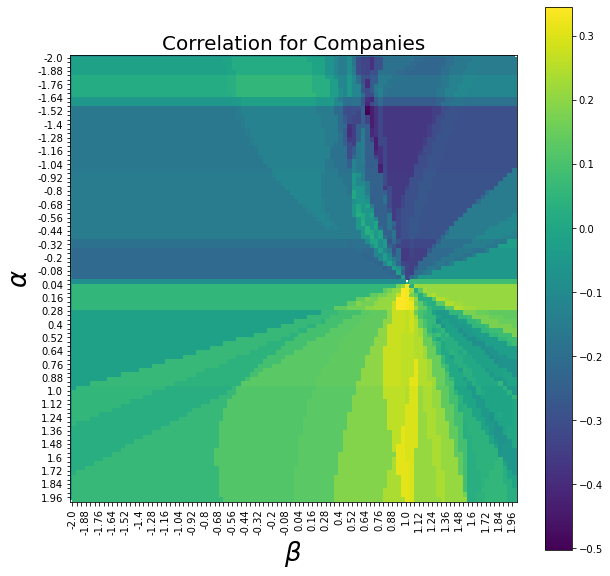

In [36]:
calibrate_analytic(M=M,
                   ua='Companies',
                   dict_class=dict_companies, 
                   exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences), 
                   index_function=lambda x: (x-50)/25,
                   title='Correlation for Companies',
                   do_plot=True)